-----------
# 1. 라이브러리 불러오기
-----------

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
from tensorflow.keras.layers import Dropout

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.6


-----------
# 2. Resize
-----------

In [10]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/scissor"
resize_images(image_dir_path)


527  images to be resized.
527  images resized.


In [11]:
# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/rock"

# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
resize_images(image_dir_path)

553  images to be resized.
553  images resized.


In [12]:
# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/paper"

# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
resize_images(image_dir_path)


623  images to be resized.
623  images resized.


-----------
# 3. 라벨링 하기
-----------

In [13]:
import numpy as np

def load_data(img_path, number_of_data=1703):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/"
(x_train, y_train) =load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 1703 입니다.
x_train shape: (1703, 28, 28, 3)
y_train shape: (1703,)


-----------
# 4. 정규화
-----------

In [14]:
from sklearn.model_selection import train_test_split
# stratify 는 각각 클래스의 비율을 유지한채 나눠줌
X_train, X_test, y_train, y_test = train_test_split(x_train,y_train,test_size = 0.2, stratify = y_train, random_state = 156)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1362, 28, 28, 3)
(341, 28, 28, 3)
(1362,)
(341,)


In [16]:
print('X_train 최소값:',np.min(X_train), 'X_train 최대값:',np.max(X_train))
print('X_test 최소값:',np.min(X_test), 'X_test 최대값:',np.max(X_test))

X_train 최소값: 0 X_train 최대값: 255
X_test 최소값: 0 X_test 최대값: 255


In [17]:
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0

In [18]:
print('X_train 최소값:',np.min(X_train_norm), 'X_train 최대값:',np.max(X_train_norm))
print('X_test 최소값:',np.min(X_test_norm), 'X_test 최대값:',np.max(X_test_norm))

X_train 최소값: 0.0 X_train 최대값: 1.0
X_test 최소값: 0.0 X_test 최대값: 1.0


-----------
# 5. 딥러닝 네트워크 설계 및 학습 시키기
-----------



일단 Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')의 파라미터는 다음과 같습니다.

- in_channels: 입력 채널 수을 뜻합니다. 흑백 이미지일 경우 1, RGB 값을 가진 이미지일 경우 3 을 가진 경우가 많습니다.
- out_channels: 출력 채널 수을 뜻합니다.
- kernel_size: 커널 사이즈를 뜻합니다. int 혹은 tuple이 올 수 있습니다.
- stride: 필터가 한번에 얼마나 이동할 것인지. int 혹은 tuple이 올 수 있습니다. 기본 값은 1입니다.
- padding: padding 사이즈를 뜻합니다. int 혹은 tuple이 올 수 있습니다. 기본 값은 0입니다.
- padding_mode: padding mode를 설정할 수 있습니다. 기본 값은 'zeros' 입니다. 아직 zero padding만 지원 합니다.
- dilation: 커널 사이 간격 사이즈를 조절 합니다. 해당 링크를 확인 하세요.
- groups: 입력 층의 그룹 수을 설정하여 입력의 채널 수를 그룹 수에 맞게 분류 합니다. 그 다음, 출력의 채널 수를 그룹 수에 맞게 분리하여, 입력 그룹과 출력 그룹의 짝을 지은 다음 해당 그룹 안에서만 연산이 이루어지게 합니다.
- bias: bias 값을 설정 할 지, 말지를 결정합니다. 기본 값은 True 입니다

참고 블로그 (https://justkode.kr/deep-learning/pytorch-cnn)

--------
현재 딥러닝 레이어는 conv2D / maxpooling / Faltten / dense의 과정을 지나고있다.  
분류 문제의딥러닝레이어는 conv2D의 레이어가 많고, maxpool과 dense가 적을때, accuracy가 높다고 한다.
Test를 통해 검증해 해보려 한다.

----

### Test 1 

conv2D의 층이 3개 / maxpool이 2개 / Dense의층이 2개

In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3),padding='same'))
model.add(keras.layers.Conv2D(32, (2,2), activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (2,2), activation='relu',padding='same'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  8
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (

In [20]:
# (데이터갯수, 이미지 크기 x, 이미지 크기 y, 채널수)
# 채널수에 대한 정보 추가
# 1은 흑백 / 컬러는 RGB값이라서 3
print("Before Reshape - X_train_norm shape: {}".format(X_train_norm.shape))
print("Before Reshape - X_test_norm shape: {}".format(X_test_norm.shape))

X_train_reshaped = X_train_norm.reshape( -1, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.
X_test_reshaped = X_test_norm.reshape( -1, 28, 28, 3)

print("After Reshape - X_train_reshaped shape: {}".format(X_train_reshaped.shape))
print("After Reshape - X_test_reshaped shape: {}".format(X_test_reshaped.shape))
# model 학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

Before Reshape - X_train_norm shape: (1362, 28, 28, 3)
Before Reshape - X_test_norm shape: (341, 28, 28, 3)
After Reshape - X_train_reshaped shape: (1362, 28, 28, 3)
After Reshape - X_test_reshaped shape: (341, 28, 28, 3)


In [21]:
model.fit(X_train_reshaped, y_train, epochs=10)
# 모델 시험
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/10
43/43 [==============================] - 3s 42ms/step - loss: 1.0750 - accuracy: 0.4031
Epoch 2/10
43/43 [==============================] - 2s 44ms/step - loss: 0.7690 - accuracy: 0.6645
Epoch 3/10
43/43 [==============================] - 2s 42ms/step - loss: 0.5251 - accuracy: 0.7592
Epoch 4/10
43/43 [==============================] - 2s 42ms/step - loss: 0.4217 - accuracy: 0.8186
Epoch 5/10
43/43 [==============================] - 2s 42ms/step - loss: 0.3628 - accuracy: 0.8495
Epoch 6/10
43/43 [==============================] - 2s 42ms/step - loss: 0.3273 - accuracy: 0.8620
Epoch 7/10
43/43 [==============================] - 2s 43ms/step - loss: 0.2659 - accuracy: 0.8994
Epoch 8/10
43/43 [==============================] - 2s 43ms/step - loss: 0.2372 - accuracy: 0.9082
Epoch 9/10
43/43 [==============================] - 2s 42ms/step - loss: 0.1860 - accuracy: 0.9258
Epoch 10/10
43/43 [==============================] - 2s 43ms/step - loss: 0.1359 - accuracy: 0.9574
11/11 - 0

--------
### Test 2 

conv2D의 층이 3개 / maxpool이 2개 / Dense의층이 3개

In [22]:
model2=keras.models.Sequential()
model2.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3),padding='same'))
model2.add(keras.layers.Conv2D(32, (2,2), activation='relu',padding='same'))
model2.add(keras.layers.MaxPool2D(2,2))
model2.add(keras.layers.Conv2D(64, (2,2), activation='relu',padding='same'))
model2.add(keras.layers.MaxPooling2D(2,2))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(64, activation='relu'))
model2.add(keras.layers.Dense(32, activation='relu'))
model2.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model2.layers))

model2.summary()

Model에 추가된 Layer 개수:  9
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        2080      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (

In [23]:
model2.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [24]:
model2.fit(X_train_reshaped, y_train, epochs=10)

# 모델 시험
test_loss, test_accuracy = model2.evaluate(X_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/10
43/43 [==============================] - 2s 44ms/step - loss: 1.1019 - accuracy: 0.3532
Epoch 2/10
43/43 [==============================] - 2s 43ms/step - loss: 1.0861 - accuracy: 0.3994
Epoch 3/10
43/43 [==============================] - 2s 42ms/step - loss: 0.9983 - accuracy: 0.5382
Epoch 4/10
43/43 [==============================] - 2s 42ms/step - loss: 0.7136 - accuracy: 0.6982
Epoch 5/10
43/43 [==============================] - 2s 42ms/step - loss: 0.5002 - accuracy: 0.8003
Epoch 6/10
43/43 [==============================] - 2s 42ms/step - loss: 0.3906 - accuracy: 0.8532
Epoch 7/10
43/43 [==============================] - 2s 43ms/step - loss: 0.3407 - accuracy: 0.8583
Epoch 8/10
43/43 [==============================] - 2s 43ms/step - loss: 0.2841 - accuracy: 0.8877
Epoch 9/10
43/43 [==============================] - 2s 42ms/step - loss: 0.2181 - accuracy: 0.9207
Epoch 10/10
43/43 [==============================] - 2s 42ms/step - loss: 0.1827 - accuracy: 0.9391
11/11 - 0

--------
### Test 3 

conv2D의 층이 3개 / maxpool이 1개 / Dense의층이 2개

In [30]:
model3=keras.models.Sequential()
model3.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3),padding='same'))
model3.add(keras.layers.Conv2D(32, (2,2), activation='relu',padding='same'))
model3.add(keras.layers.Conv2D(64, (2,2), activation='relu',padding='same'))
model3.add(keras.layers.MaxPooling2D(2,2))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(64, activation='relu'))
model3.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model3.layers))

model3.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        2080      
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 64)        8256      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 12544)             0         
                                                                 
 dense_13 (Dense)            (None, 64)                802880    
                              

In [31]:
model3.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model3.fit(X_train_reshaped, y_train, epochs=10)

# 모델 시험
test_loss, test_accuracy = model3.evaluate(X_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/10
43/43 [==============================] - 4s 77ms/step - loss: 1.0646 - accuracy: 0.4831
Epoch 2/10
43/43 [==============================] - 3s 78ms/step - loss: 0.7694 - accuracy: 0.6982
Epoch 3/10
43/43 [==============================] - 3s 77ms/step - loss: 0.4979 - accuracy: 0.8062
Epoch 4/10
43/43 [==============================] - 3s 79ms/step - loss: 0.2925 - accuracy: 0.9053
Epoch 5/10
43/43 [==============================] - 3s 78ms/step - loss: 0.1803 - accuracy: 0.9383
Epoch 6/10
43/43 [==============================] - 3s 78ms/step - loss: 0.1025 - accuracy: 0.9728
Epoch 7/10
43/43 [==============================] - 3s 77ms/step - loss: 0.0938 - accuracy: 0.9743
Epoch 8/10
43/43 [==============================] - 3s 78ms/step - loss: 0.0570 - accuracy: 0.9868
Epoch 9/10
43/43 [==============================] - 3s 78ms/step - loss: 0.0309 - accuracy: 0.9971
Epoch 10/10
43/43 [==============================] - 3s 77ms/step - loss: 0.0174 - accuracy: 0.9971
11/11 - 0

--------
### Test 4 

conv2D의 층이 4개 / maxpool이 1개 / Dense의층이 2개

In [34]:
model4=keras.models.Sequential()
model4.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3),padding='same'))
model4.add(keras.layers.Conv2D(32, (2,2), activation='relu',padding='same'))
model4.add(keras.layers.Conv2D(64, (2,2), activation='relu',padding='same'))
model4.add(keras.layers.Conv2D(128, (2,2), activation='relu',padding='same'))
model4.add(keras.layers.MaxPooling2D(2,2))
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(64, activation='relu'))
model4.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model4.layers))

model4.summary()

Model에 추가된 Layer 개수:  8
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 28, 32)        2080      
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 64)        8256      
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 128)       32896     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                              

In [35]:
model4.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model4.fit(X_train_reshaped, y_train, epochs=10)

# 모델 시험
test_loss, test_accuracy = model4.evaluate(X_test_reshaped, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/10
43/43 [==============================] - 9s 182ms/step - loss: 1.0892 - accuracy: 0.4192
Epoch 2/10
43/43 [==============================] - 8s 182ms/step - loss: 0.7429 - accuracy: 0.6667
Epoch 3/10
43/43 [==============================] - 8s 183ms/step - loss: 0.5459 - accuracy: 0.7474
Epoch 4/10
43/43 [==============================] - 8s 183ms/step - loss: 0.4497 - accuracy: 0.7900
Epoch 5/10
43/43 [==============================] - 8s 185ms/step - loss: 0.3499 - accuracy: 0.8568
Epoch 6/10
43/43 [==============================] - 8s 184ms/step - loss: 0.2714 - accuracy: 0.8869
Epoch 7/10
43/43 [==============================] - 8s 183ms/step - loss: 0.1974 - accuracy: 0.9222
Epoch 8/10
43/43 [==============================] - 8s 183ms/step - loss: 0.1104 - accuracy: 0.9640
Epoch 9/10
43/43 [==============================] - 8s 183ms/step - loss: 0.0803 - accuracy: 0.9743
Epoch 10/10
43/43 [==============================] - 8s 183ms/step - loss: 0.0435 - accuracy: 0.9853

- Test1(0.9589)과 Test2(0.9421)를 비교해본 결과 Dense가 적을수록 accuracy가 높음을 확인했음  
- Test2(0.9421)와 Test3(0.9970)를 비교해본 결과 Maxpool이 적을수록 accuracy가 높음을 확인했음
- Test4의경우 Conv2D레이어의 개수가 많지만 오히려accuracy가 떨어지는 모습을 볼수있다.   
데이터에 따라서 레이어의 적절한 개수를 찾는것이 중요하다고 생각된다.

----------

In [ ]:
# model.evaluate() 대신 model.predict()를 사용하면 model의 입력값을 보고 실제로 추론한 확률분포를 출력

predicted_result = model4.predict(X_test_reshaped)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=12 
print('model4.predict() 결과 : ', predicted_result[idx])
print('model4이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model4.predict() 결과 :  [9.5360148e-01 1.7833108e-06 4.6396725e-02]
model4이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


### 틀린 데이터 확인

32
예측확률분포: [9.4124383e-01 9.4841571e-06 5.8746643e-02]
라벨: 2, 예측결과: 0


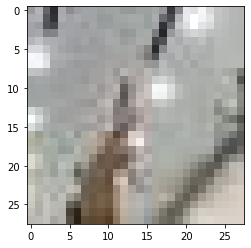

예측확률분포: [5.8607608e-01 1.2823931e-07 4.1392374e-01]
라벨: 2, 예측결과: 0


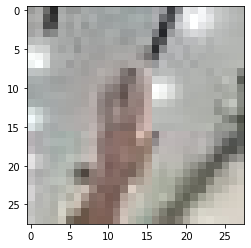

예측확률분포: [7.3992640e-01 1.8855817e-04 2.5988504e-01]
라벨: 2, 예측결과: 0


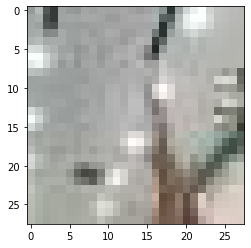

예측확률분포: [7.5326425e-01 2.1263222e-04 2.4652319e-01]
라벨: 2, 예측결과: 0


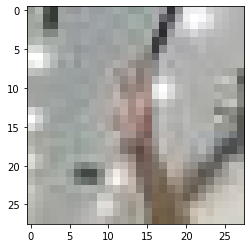

예측확률분포: [8.7399542e-01 1.3453737e-05 1.2599115e-01]
라벨: 2, 예측결과: 0


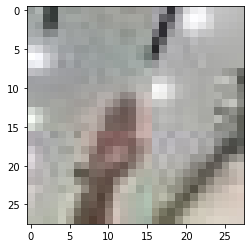

In [ ]:
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
print(len(wrong_predict_list))
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(X_test[n], cmap=plt.cm.binary)
    plt.show()

-----------
# 6. 테스트 해보기

직접 촬영한 데이터와 다른 사람들의 추가적인 데이터를 합쳐서 재학습

-----------


In [36]:
def resize_images(img_path):
  images = glob.glob(img_path + "/*.png") + glob.glob(img_path + "/*.jpg")

  # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
  target_size=(28,28)
	
  for img in images:
	  old_img=Image.open(img).convert('RGB')
	  new_img=old_img.resize(target_size,Image.ANTIALIAS)
	  new_img.save(img, "JPEG")
    
  print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/final_test/rock/"
resize_images(image_dir_path)


1517  images resized.


In [37]:
# 테스트 데이터(가위) 이미지 크기 맞추기
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/final_test/scissor"
resize_images(image_dir_path)

1489  images resized.


In [38]:
# 테스트 데이터(바위) 이미지 크기 맞추기
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/final_test/rock"
resize_images(image_dir_path)

1517  images resized.


In [39]:
# 테스트 데이터(보) 이미지 크기 맞추기
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/final_test/paper"
resize_images(image_dir_path)

1587  images resized.


In [40]:
def load_test_data(img_path, number_of_data=4593):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1
    for file in glob.iglob(img_path+'/scissor/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    for file in glob.iglob(img_path+'/rock/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
    for file in glob.iglob(img_path+'/paper/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트 데이터(outer_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [41]:
# 테스트 데이터 분리
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/final_test"
(total_train, total_test) = load_test_data(image_dir_path)

테스트 데이터(outer_test)의 이미지 개수는 4593 입니다.


In [42]:
from sklearn.model_selection import train_test_split

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(total_train,total_test, stratify = total_test, test_size = 0.2, random_state = 156)

In [43]:
print(X_train_final.shape)
print(X_test_final.shape)
print(y_train_final.shape)
print(y_test_final.shape)

(3674, 28, 28, 3)
(919, 28, 28, 3)
(3674,)
(919,)


In [44]:
print("X_train_final shape: {}".format(X_train_final.shape))
print("X_test_final shape: {}".format(X_test_final.shape))

X_train_final shape: (3674, 28, 28, 3)
X_test_final shape: (919, 28, 28, 3)


In [45]:
print('X_train_final 최소값:',np.min(X_train_final), 'X_train_final 최대값:',np.max(X_train_final))
print('X_test_final 최소값:',np.min(X_test_final), 'X_test_final 최대값:',np.max(X_test_final))

X_train_final 최소값: 0 X_train_final 최대값: 255
X_test_final 최소값: 0 X_test_final 최대값: 255


In [46]:
# 테스트 데이터도 동일하게 정규화
X_train_final_norm = X_train_final / 255.0
X_test_final_norm = X_test_final / 255.0

In [47]:
# 채널수에 대한 정보 추가
print("Before Reshape - X_train_final_shape: {}".format(X_train_final_norm.shape))
print("Before Reshape - X_test_final_shape: {}".format(X_test_final_norm.shape))

X_train_final_reshaped = X_train_final_norm.reshape( -1, 28, 28, 3)
X_test_final_reshaped = X_test_final_norm.reshape( -1, 28, 28, 3)

print("After Reshape - X_train_final_reshaped shape: {}".format(X_train_final_reshaped.shape))
print("After Reshape - X_test_final_reshaped shape: {}".format(X_test_final_reshaped.shape))

Before Reshape - X_train_final_shape: (3674, 28, 28, 3)
Before Reshape - X_test_final_shape: (919, 28, 28, 3)
After Reshape - X_train_final_reshaped shape: (3674, 28, 28, 3)
After Reshape - X_test_final_reshaped shape: (919, 28, 28, 3)


-------
# 7. TEST 데이터로 테스트 시키기
--------

In [48]:
model_final=keras.models.Sequential()
model_final.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3),padding='same'))
model_final.add(keras.layers.Conv2D(32, (2,2), activation='relu',padding='same'))
model_final.add(keras.layers.Conv2D(64, (2,2), activation='relu',padding='same'))
model_final.add(keras.layers.MaxPooling2D(2,2))
model_final.add(keras.layers.Flatten())
model_final.add(keras.layers.Dense(64, activation='relu'))
model_final.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model_final.layers))

model_final.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 32)        2080      
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 64)        8256      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 12544)             0         
                                                                 
 dense_19 (Dense)            (None, 64)                802880    
                              

In [49]:
model_final.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model_final.fit(X_train_final_reshaped, y_train_final, epochs=10)
# 모델 시험
test_loss, test_accuracy = model_final.evaluate(X_test_final_reshaped, y_test_final, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/10
115/115 [==============================] - 10s 84ms/step - loss: 0.5246 - accuracy: 0.7716
Epoch 2/10
115/115 [==============================] - 9s 81ms/step - loss: 0.0512 - accuracy: 0.9872
Epoch 3/10
115/115 [==============================] - 9s 80ms/step - loss: 0.0173 - accuracy: 0.9967
Epoch 4/10
115/115 [==============================] - 9s 78ms/step - loss: 0.0089 - accuracy: 0.9984
Epoch 5/10
115/115 [==============================] - 9s 80ms/step - loss: 0.0035 - accuracy: 0.9995
Epoch 6/10
115/115 [==============================] - 9s 80ms/step - loss: 9.9673e-04 - accuracy: 1.0000
Epoch 7/10
115/115 [==============================] - 9s 80ms/step - loss: 3.7493e-04 - accuracy: 1.0000
Epoch 8/10
115/115 [==============================] - 9s 80ms/step - loss: 4.5425e-04 - accuracy: 1.0000
Epoch 9/10
115/115 [==============================] - 9s 80ms/step - loss: 2.4275e-04 - accuracy: 1.0000
Epoch 10/10
115/115 [==============================] - 9s 80ms/step - loss

- 상위에서 accuracy가 가장 높았던 Test3와 같은 레이어층을 활용해 데이터를 학습하고 테스트해본 결과 과적합으로 인해 accuracy가 1에 가까운 수준으로 측정이 되었다.

- 하이퍼 파라미터 값 조절,Maxpool레이어 추가, Dropout를 통해 과적합의 문제를 해결해 보고자 한다.

In [52]:
model_final2=keras.models.Sequential()
model_final2.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3),padding='same'))
model_final2.add(keras.layers.MaxPool2D(2,2))
model_final2.add(keras.layers.Conv2D(32, (2,2), activation='relu',padding='same'))
model_final2.add(keras.layers.MaxPooling2D(2,2))
model_final2.add(keras.layers.Flatten())
model_final2.add(keras.layers.Dense(32, activation='relu'))
model_final2.add(keras.layers.Dropout(0.2))
model_final2.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model_final2.layers))

model_final2.summary()

Model에 추가된 Layer 개수:  8
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 14, 32)        2080      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 1568)              0         
                                                                 
 dense_21 (Dense)            

In [53]:
model_final2.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model_final2.fit(X_train_final_reshaped, y_train_final, epochs=10)
# 모델 시험
test_loss, test_accuracy = model_final2.evaluate(X_test_final_reshaped, y_test_final, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/10
115/115 [==============================] - 3s 20ms/step - loss: 1.0013 - accuracy: 0.4858
Epoch 2/10
115/115 [==============================] - 2s 19ms/step - loss: 0.5756 - accuracy: 0.7695
Epoch 3/10
115/115 [==============================] - 2s 19ms/step - loss: 0.3446 - accuracy: 0.8688
Epoch 4/10
115/115 [==============================] - 2s 20ms/step - loss: 0.2205 - accuracy: 0.9284
Epoch 5/10
115/115 [==============================] - 2s 19ms/step - loss: 0.1517 - accuracy: 0.9589
Epoch 6/10
115/115 [==============================] - 2s 20ms/step - loss: 0.0999 - accuracy: 0.9744
Epoch 7/10
115/115 [==============================] - 2s 19ms/step - loss: 0.0812 - accuracy: 0.9769
Epoch 8/10
115/115 [==============================] - 2s 20ms/step - loss: 0.0618 - accuracy: 0.9837
Epoch 9/10
115/115 [==============================] - 2s 19ms/step - loss: 0.0594 - accuracy: 0.9842
Epoch 10/10
115/115 [==============================] - 2s 19ms/step - loss: 0.0408 - accura

In [54]:
import random
select = random.choices(range(0,920), k=5)

predicted_result = model_final2.predict(X_test_final_reshaped)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

for i in select:
  idx=i  #1번째 x_test를 살펴보자. 
  print('model.predict() 결과 : ', predicted_result[idx])
  print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
  print('실제 데이터의 라벨 : ', y_test_final[idx])


model.predict() 결과 :  [9.9864477e-01 4.8132584e-05 1.3071626e-03]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0
model.predict() 결과 :  [1.000000e+00 9.359648e-16 3.327162e-19]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0
model.predict() 결과 :  [4.2297902e-06 9.9998999e-01 5.8171877e-06]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1
model.predict() 결과 :  [1.5485315e-05 9.9675572e-06 9.9997449e-01]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  2
model.predict() 결과 :  [0.99118197 0.00689092 0.00192722]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


추가된 데이터를 통해 모델에 학습시키고,x_test와 y_test를 통해 검증한결과 높은 accuracy를 보이고있다.  
하지만 데이터셋을 보았을때, 비슷비슷한 배경과 비슷한 이미지들이 많이 있음을 알수있다.  
따라서 test값을 넣어 검증 했을때,높은 정확성을 보일 수 밖에 없다고 생각이든다.


------
# 8. 다른 데이터로 테스트 해보기
모델에 학습조차 되지 않은 제3의 데이터셋을 가져와 모델에 넣어 검증을 해보도록 하겠다.


--------

In [55]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/another_test/scissor"
resize_images(image_dir_path)
# -------------------------------------------------------

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/another_test/rock"

# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
resize_images(image_dir_path)
# -------------------------------------------------------

# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/another_test/paper"

# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
resize_images(image_dir_path)
 # -------------------------------------------------------

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [56]:
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [57]:

image_dir_path = "/content/drive/MyDrive/aiffel/exp5/rock_scissor_paper/another_test/"
(another_train, another_test) =load_data(image_dir_path)


데이터의 이미지 개수는 300 입니다.


In [58]:
print("another_train_final shape: {}".format(another_train.shape))
print("another_test_final shape: {}".format(another_test.shape))

another_train_final shape: (300, 28, 28, 3)
another_test_final shape: (300,)


In [59]:
print('another_train 최소값:',np.min(another_train), 'another_train 최대값:',np.max(another_train))
print('another_test 최소값:',np.min(another_test), 'another_test 최대값:',np.max(another_test))

another_train 최소값: 0 another_train 최대값: 255
another_test 최소값: 0 another_test 최대값: 2


In [60]:
another_train_norm = another_train / 255


In [61]:
print("Before Reshape - another_train_shape: {}".format(another_train_norm.shape))

another_train_reshaped = another_train_norm.reshape( -1, 28, 28, 3)

print("After Reshape - X_train_final_reshaped shape: {}".format(another_train_reshaped.shape))

Before Reshape - another_train_shape: (300, 28, 28, 3)
After Reshape - X_train_final_reshaped shape: (300, 28, 28, 3)


In [63]:
test_loss, test_accuracy = model_final2.evaluate(another_train_reshaped, another_test, verbose=2)

10/10 - 0s - loss: 1.4226 - accuracy: 0.5567 - 76ms/epoch - 8ms/step


In [69]:
# 임의로 10개를 추출해 맞은 데이터 확인
import random
select = random.choices(range(0,301), k=10)

predicted_result = model_final2.predict(another_train_reshaped)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)
count = 0
for i in select:
  idx=i  #1번째 x_test를 살펴보자. 
  print('model.predict() 결과 : ', predicted_result[idx])
  print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
  print('실제 데이터의 라벨 : ', another_test[idx])
  
  if predicted_labels[idx] == another_test[idx]:
    count = count + 1
print('='*70)
print(count / 10 * 100 ,'%')
print('='*70)

model.predict() 결과 :  [0.00140124 0.997414   0.00118468]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1
model.predict() 결과 :  [0.01236197 0.00616576 0.98147225]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0
model.predict() 결과 :  [0.25996137 0.6990649  0.04097367]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1
model.predict() 결과 :  [0.42666376 0.4416798  0.13165641]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1
model.predict() 결과 :  [0.19768888 0.33535913 0.46695203]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  2
model.predict() 결과 :  [0.307214   0.00139659 0.6913894 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0
model.predict() 결과 :  [0.02440668 0.01659371 0.9589996 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0
model.predict() 결과 :  [1.4465980e-04 9.9980050e-01 5.4874898e-05]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1
model.predict() 결과 :  [0.03871364 0.92163235 0.03965398]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1
model.predict() 결과 :  [0.0735551  0.8539273  0.07251754]
model이 

랜덤한 값을 뽑아내기 때문에 매번 달라지기는 하지만 accuracy의 값과 비슷하게 맞추는것을 알수있다.  
딥러닝의 경우 데이터수가 적어 예측의 정확도가 낮을 수 있기 때문에   
데이터증강을 통해 학습 데이터셋을 증가시키고 위와 동일하게 제3의 데이셋을 통해 검증을 진행해보도록 하겠다.

--------
## 9. 데이터 증강
--------

- rescale = 1./255 : 값을 0과 1 사이로 변경
- rotation_range = 30 : 무작위 회전각도 30도 이내
- shear_range = 0.2 : 층밀리기 강도 20% 
- zoom_range = 0.2 : 무작위 줌 범위 20%
- horizontal_flip = True : 무작위로 가로로 뒤짚는다.

참고 블로그 (https://acdongpgm.tistory.com/169)

In [80]:
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator 객체 생성 -> 적용할 증강 기법 설정
tr_gen = ImageDataGenerator(vertical_flip=True, rotation_range=0.3,shear_range=0.2)

# Numpy Array Iterator 객체 생성하여 모델 인풋으로 배치 사이즈만큼 집어넣을 준비
flow_tr_gen = tr_gen.flow(x=X_train_final_reshaped, y=y_train_final, batch_size=6, shuffle=True)

In [81]:
model_final3=keras.models.Sequential()
model_final3.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model_final3.add(keras.layers.MaxPool2D(2,2))
model_final3.add(keras.layers.Flatten())
model_final3.add(keras.layers.Dense(64, activation='relu'))
model_final3.add(keras.layers.Dropout(0.35))
model_final3.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model_final3.layers))

model_final3.summary()

Model에 추가된 Layer 개수:  6
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 2704)              0         
                                                                 
 dense_27 (Dense)            (None, 64)                173120    
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 3)                 195       
                             

In [82]:
model_final3.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [83]:
model_final3.fit(
  flow_tr_gen, epochs=5, validation_data=(another_train_reshaped, another_test)
)

Epoch 1/5
613/613 [==============================] - 5s 8ms/step - loss: 0.8955 - accuracy: 0.5648 - val_loss: 1.0889 - val_accuracy: 0.4300
Epoch 2/5
613/613 [==============================] - 5s 8ms/step - loss: 0.3700 - accuracy: 0.8783 - val_loss: 1.3182 - val_accuracy: 0.4800
Epoch 3/5
613/613 [==============================] - 5s 8ms/step - loss: 0.1878 - accuracy: 0.9445 - val_loss: 1.3194 - val_accuracy: 0.6333
Epoch 4/5
613/613 [==============================] - 5s 8ms/step - loss: 0.1276 - accuracy: 0.9578 - val_loss: 1.7262 - val_accuracy: 0.5867
Epoch 5/5
613/613 [==============================] - 5s 8ms/step - loss: 0.0918 - accuracy: 0.9711 - val_loss: 1.8086 - val_accuracy: 0.6133


In [89]:
import random
select = random.choices(range(0,301), k=10)

predicted_result = model_final3.predict(another_train_reshaped)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

count = 0
for i in select:
  idx=i 
  print('model.predict() 결과 : ', predicted_result[idx])
  print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
  print('실제 데이터의 라벨 : ', another_test[idx])

  if predicted_labels[idx] == another_test[idx]:
    count = count + 1
print('='*70)
print(count / 10 * 100 ,'%')
print('='*70)

model.predict() 결과 :  [0.00295873 0.07004005 0.9270012 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  2
model.predict() 결과 :  [0.6249896  0.03630781 0.3387026 ]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  1
model.predict() 결과 :  [0.23805422 0.66182613 0.1001196 ]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1
model.predict() 결과 :  [0.02114356 0.96520054 0.01365585]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1
model.predict() 결과 :  [0.39440536 0.00590546 0.5996892 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0
model.predict() 결과 :  [0.1000638  0.88341856 0.01651761]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1
model.predict() 결과 :  [9.9909127e-01 2.0526448e-04 7.0355606e-04]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0
model.predict() 결과 :  [1.7804947e-01 5.6901475e-04 8.2138145e-01]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  2
model.predict() 결과 :  [0.42560852 0.00150095 0.57289046]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  1
model.predict() 결과 :  [0.80674213 0.00548558 0.18777221

데이터 증강을 통해 이전 모델보다는 학습의 정확도가 증가했음을 알 수 있다.

-------
# 10. 회고
- 비슷한 데이터셋을 통해 모델에 학습을 시켰기 때문에 accuracy의 값은 높게 나올 수 밖에 없다고 판단하여 제3의 데이터를 통해 검증을 진행하게 되었다.
- 레이어를 쌓고 모델을 학습시켜보면서 매번 loss와 accuracy가 달라지는 것을 보고 해당 부분에 대한 이해와 지식이 조금 더 필요하다고 생각이 들었다.
- 조금의 경험이었지만, 일반화된 모델을 만다는것에 대한 어려움을 느낄 수 있는 회차였다.